## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

#### Prepare English dictionary for language detection

In [5]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [7]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [8]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 10% English words
#### Also, make the mentions of usernames and URLs generic

In [9]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             t["tweet_data"]["full_text"]))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [10]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [11]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [12]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

In [13]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

#### Show examples

In [14]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
Rolex this, Omega that ➊


In [15]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Bro stop lying thats not how this works ➊


#### Find the length of the smaller dataset

In [16]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [17]:
subtweets_data = sample(subtweets_data, smallest_length)

In [18]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [19]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11285


#### Prepare data for training

In [20]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [21]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [22]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames and URLs, as well as common English first names

In [23]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [24]:
generic_tokens = {"➊", "➋"}

In [25]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [26]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [27]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [28]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7083    0.6577    0.6821      1078
    subtweet     0.7062    0.7523    0.7285      1179

 avg / total     0.7072    0.7071    0.7063      2257

Test Data Accuracy: 0.7071

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9837    0.9784    0.9811     10207
    subtweet     0.9783    0.9837    0.9810     10106

 avg / total     0.9811    0.9810    0.9810     20313

Train Data Accuracy: 0.9810

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7263    0.6586    0.6908      1116
    subtweet     0.6940    0.7572    0.7242      1141

 avg / total     0.7100    0.7085    0.7077      2257

Test Data Accuracy: 0.7085

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9860    0.9754    0.9807     10169
    subtweet     0.9756    0.9861    0.9808     10144



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [29]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [30]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 1.95 s, sys: 49.2 ms, total: 2 s
Wall time: 2.04 s


In [31]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [32]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [33]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(25)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #absapremiership,-12.9908,.,-7.5274
1,! ! #beredseered,-12.9908,",",-7.8987
2,! ! #cholecystectomy,-12.9908,"""",-8.0402
3,! ! #dwts26,-12.9908,people,-8.3571
4,! ! #frustrated,-12.9908,?,-8.4125
5,! ! #goblue,-12.9908,don't,-8.5773
6,! ! #goldenkamuy,-12.9908,like,-8.5809
7,! ! #happyeasterfromhell,-12.9908,just,-8.6280
8,! ! #icanonlyimagine,-12.9908,i'm,-8.7210
9,! ! #ipl2018,-12.9908,!,-8.7620


#### Define function for visualizing confusion matrices

In [34]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

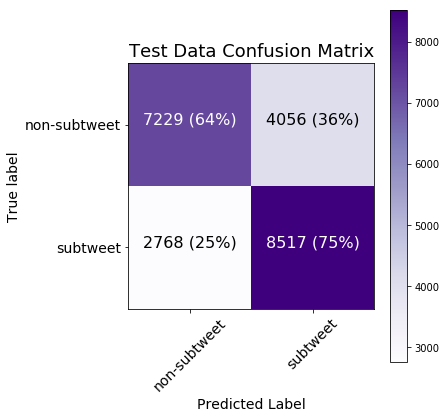

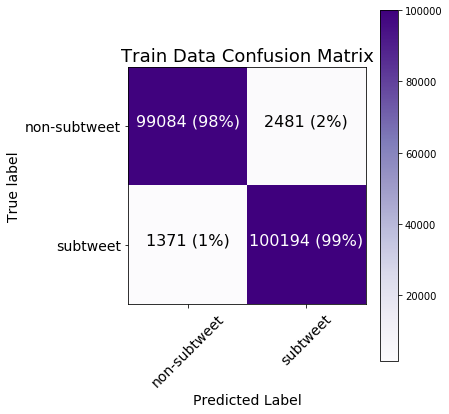

In [35]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [36]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [37]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [38]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [39]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [40]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 10 s, sys: 235 ms, total: 10.2 s
Wall time: 11.5 s


#### Show a random table

In [41]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
2137,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯,2015-06-15 17:24:46,1,0,610558590278070272,0.9049
2151,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯,2015-06-13 08:44:07,0,0,609702789896372224,0.8822
2073,"""i do have aids ¯\_(ツ)_/¯. That's what happens when you're super gay"" #quotesfromwork",2015-06-30 13:10:20,0,0,615930378822492160,0.8765
1936,"when can i include ""twitter personality"" in my bio",2015-07-23 23:59:49,2,0,624428746578202624,0.8762
1671,I love it when people just copy tweets to gain popularity ➌ @➋,2015-12-15 20:25:49,1,1,676936232530743296,0.8579


#### Prepare statistics on tweets

In [42]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [43]:
test_df_stats = tests_df.describe()

In [44]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [45]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5235,0.5184,0.5595,0.5307,0.5303,0.5052,0.4484,0.5441,0.5294,0.4532,0.5456,0.5137,0.5487,0.5463
std,0.1129,0.1266,0.1203,0.1188,0.1103,0.1172,0.1051,0.1242,0.1154,0.1056,0.1256,0.1200,0.1237,0.1109
min,0.2338,0.1095,0.1386,0.1379,0.1161,0.0663,0.1325,0.1593,0.1359,0.1478,0.0784,0.0630,0.1563,0.0718
25%,0.4432,0.4292,0.4792,0.4512,0.4549,0.4339,0.3798,0.4588,0.4519,0.3889,0.4674,0.4360,0.4675,0.4786
50%,0.5194,0.5166,0.5568,0.5257,0.5316,0.5002,0.4508,0.5373,0.5274,0.4559,0.5449,0.5097,0.5563,0.5473
75%,0.6012,0.6024,0.6411,0.6127,0.6019,0.5816,0.5159,0.6304,0.6015,0.5194,0.6303,0.5923,0.6277,0.6214
max,0.8480,0.9049,0.8717,0.8963,0.9147,0.8938,0.7807,0.8635,0.8817,0.7523,0.8933,0.9407,0.8556,0.8828


#### Plot a histogram with three random users

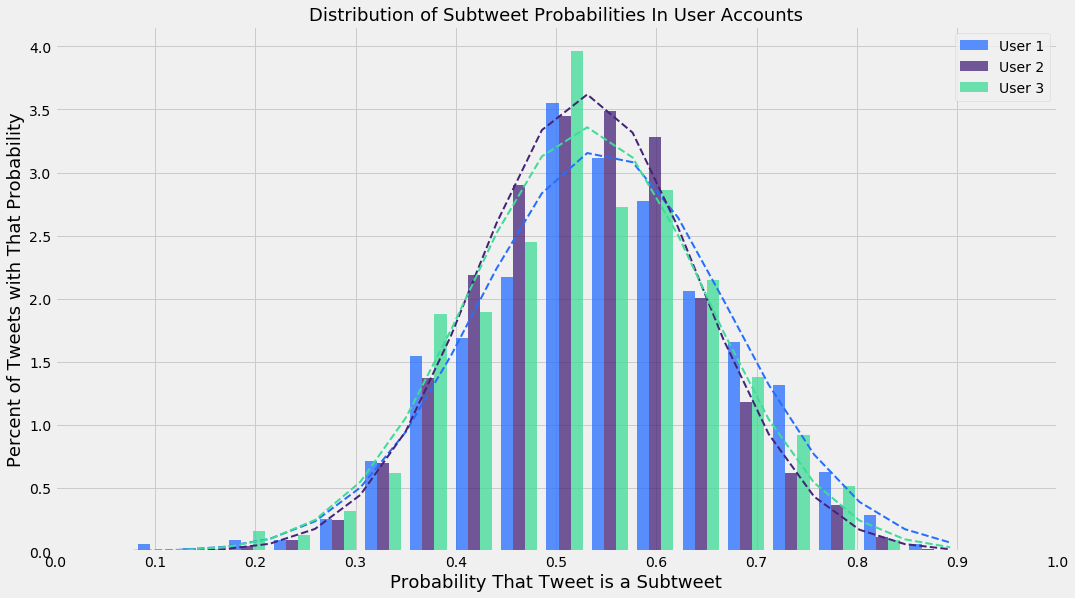

In [46]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [47]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [48]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5239
std,0.1196
min,0.0630
25%,0.4442
50%,0.5209
75%,0.6029
max,0.9407


#### Now plot

No handles with labels found to put in legend.


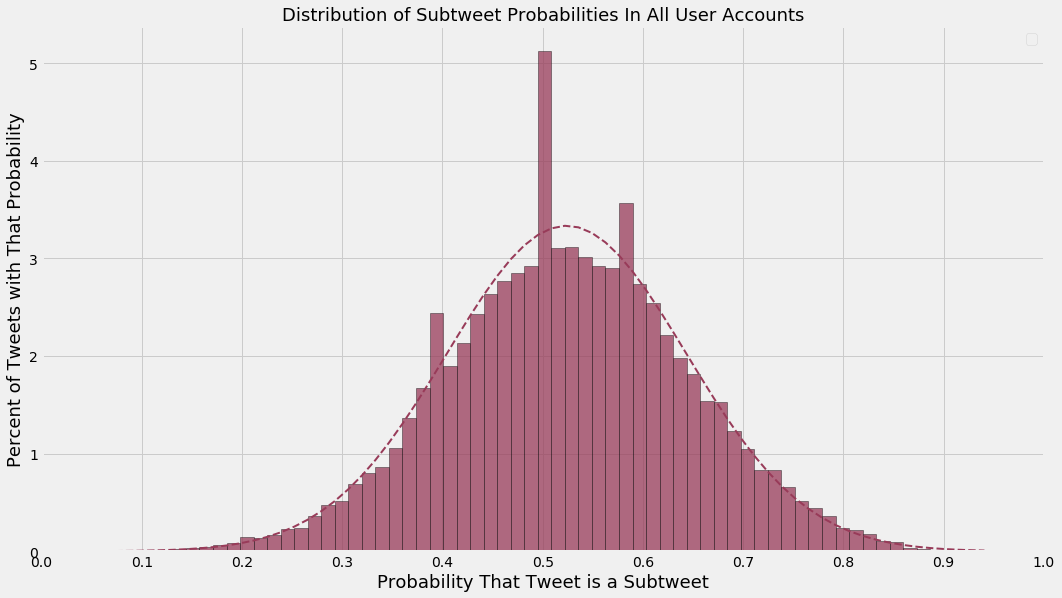

In [49]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [50]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")) for tweet in training_data]

#### Lengths

In [51]:
length_data = [len(tweet) for tweet in training_data]

In [52]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [53]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [54]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [55]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [56]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
13517,293,Again.. you worship a xenophobic God and a Bible that promotes hate as long as you don't ignore all those parts.. a God that sends people to burn in Hell forever for not believing in him....you don't get to call those talking with you haters!
19144,281,Still looking to sell a couple of customs! Make your fantasies come true with me as the sexy star for just $50! Don't be scared to ask me about your fetish's I love to try new ones and I find them so fun! I'm always looking to try new stuff or revisit some classics so message me!
14870,281,"""Advisory equity @ 1-5% helps the mentor be aligned to the startup"" \n\nThis is insane crap! Advisory equity in early stage startups (if at all) shld be of order ~ 0.10% - 0.25%. Anything more means misaligned incentives.. the startup is either clueless or being taken for a ride!"
21495,281,"2 white male cops slammed this Black woman, threatened to, ""break her arm,"" and exposed her breast. Her ""crime,"" as a paying customer, was asking for ""corporates number."" \n\nIt's not just Starbucks. It's potentially ALL spaces when company policy, cops and anti-Blackness converge."
19614,281,"Enthralled by Raja Shiv Chhatrapati, a well mounted magnum opus on life of the Maratha warrior at Red Fort. Vividly brought out his philosophies, struggles, inspiration from mother Jijayee & penchant for gender equality through well conceived music, dance & dialogues. A must see!"


#### Top 5 shortest tweets

In [57]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
3939,4,Fake
3229,4,soft
1911,4,Lame
17674,4,fear
457,4,Rude


#### Tweet length statistics

In [58]:
length_data_for_stats.describe()

,Length
count,22570.0000
mean,104.0716
std,73.5631
min,4.0000
25%,46.0000
50%,84.0000
75%,145.0000
max,293.0000


#### Punctuation

In [59]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [60]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [61]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
3738,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
11373,11,(•_•)\n<) )\ I am no Wonder Woman\n / \\n\n\(•_•)\n ( (> I am not Supergirl\n / \\n\n\(-_•)/\n OO I am Power Girl!\n ) ( \n / \\n\n (•_•)\n <OO> #Bitchez \n ) (\n | |
20112,11,"[BanG Dream Girls Band Party Seiyuu Profiles Arpil 2018 Edition]\nOrder of Posting:\n- Hello, Happy World (4/8)\n- Roselia (4/8)\n- Pastel*Palettes (4/9)\n- Afterglow (4/9)\n- Poppin'Party (4/10)\n\nLet's go!"
22387,10,"10,000 #Fortnite V-Bucks Giveaway!\n 🔥$100.00 PayPal🔥\n\n1. Retweet This Tweet\n2. Follow & Myself\n3. Tag a friend for x2 Entry (optional)\n\nDrawing Winner in 48 Hours! \n(04/02/18) Good Luck!"
17779,10,"USA's share of global GDP was about 50% after WW2, today it is about 15%. It will further decline this century (although its economy & GDP/capita will continue to grow in absolute terms).\n\nHow will America react to this loss of ""relative power""? By all indications, rather badly."


#### Tweets punctuation statistics

In [62]:
punctuation_data_for_stats.describe()

,Punctuation
count,22570.0000
mean,1.9794
std,1.6362
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [63]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [64]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [65]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
11285,8,my dream was so weird last night
12810,8,Sideline looking like a Fortnite pre-game lobby
12795,8,maybe i should give hot mulligan & homesafe a listen since i always see people talking about much they love them on my tl 🤔
12796,8,"Okay, so I was just cruising through Pinterest and I stumbled across wooden countertops.. Is that a thing?\n\nAlso, I kind of like them. What do you guys think?? (You won't hurt my feelings if you hate them, I just honestly didn't know it was a thing)"
12797,8,Life is a whirlwind of emotions right now but so many dope things on the horizon


#### Top 5 tweets with fewest stop words

In [66]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
11325,0,When
5049,0,𝓸𝓵𝓲𝓿𝓲𝓪'𝓼 𝕣𝕒𝕟𝕕𝕠𝕞 𝙦𝙪𝙚𝙨𝙩𝙞𝙤𝙣 𝙩𝙝𝙧𝙚𝙖𝙙.
10556,0,We been knew
760,0,Clever.
12419,0,fuck u


#### Tweets stop words statistics

In [67]:
stop_words_data_for_stats.describe()

,Stop words
count,22570.0000
mean,7.1026
std,1.3474
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [68]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [69]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [70]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [71]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [72]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
15652,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
2056,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
19094,"ur bday 21/8 u50. Fancy a kick about the park where we used to play.?Jumpers down- shots.Then 3 holes of golf.we hit any windows we run!What do u say- will be a laugh.I am 50 a week later.hey, we're still kind of fit:))give me a shout if up 4 it 07532203285 Liam",58
20570,"-Many👮‍♂️suffer in silence, not always by choice but by design! #PTSD can be a career killer & worse many PD's DO NOT see P.T.S.D as an insured disability; This has to change🆘- Hiding mine for 3 years made my #Fight unbearable!\n\nPlease help us #UnmaskPTSD & #SaveOurLives ⚖️",58
11109,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57


#### Top 5 tweets with fewest unique words

In [73]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
11257,assumptions,1
3444,DONE,1
12009,DISAGREE,1
21197,FUCK,1
9824,Disgusting,1


#### Tweets unique words statistics

In [74]:
unique_words_data_for_stats.describe()

,Unique words
count,22570.0000
mean,18.7036
std,11.8781
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

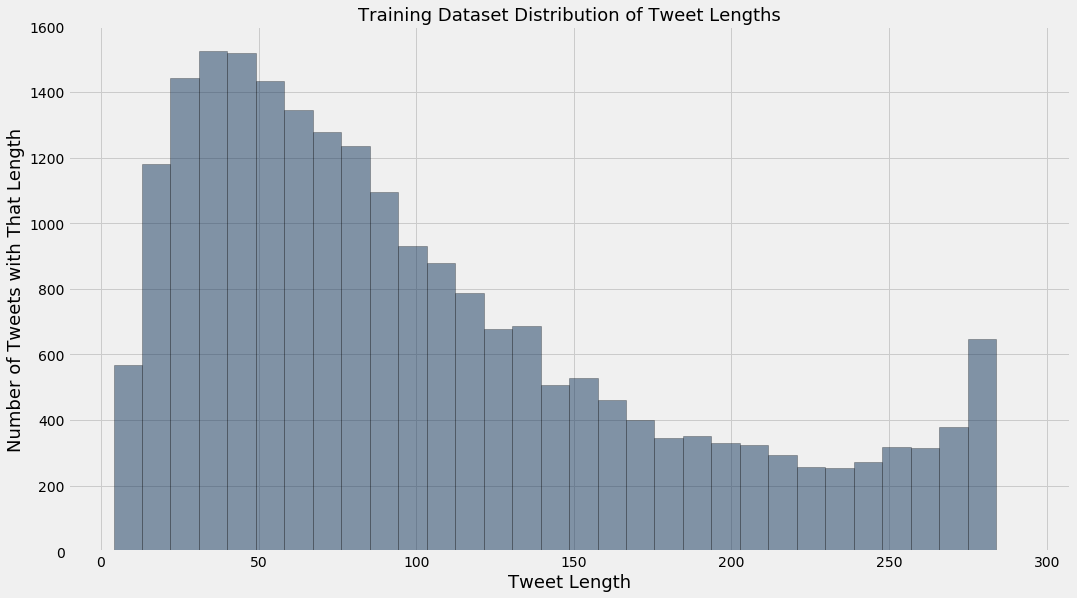

In [75]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

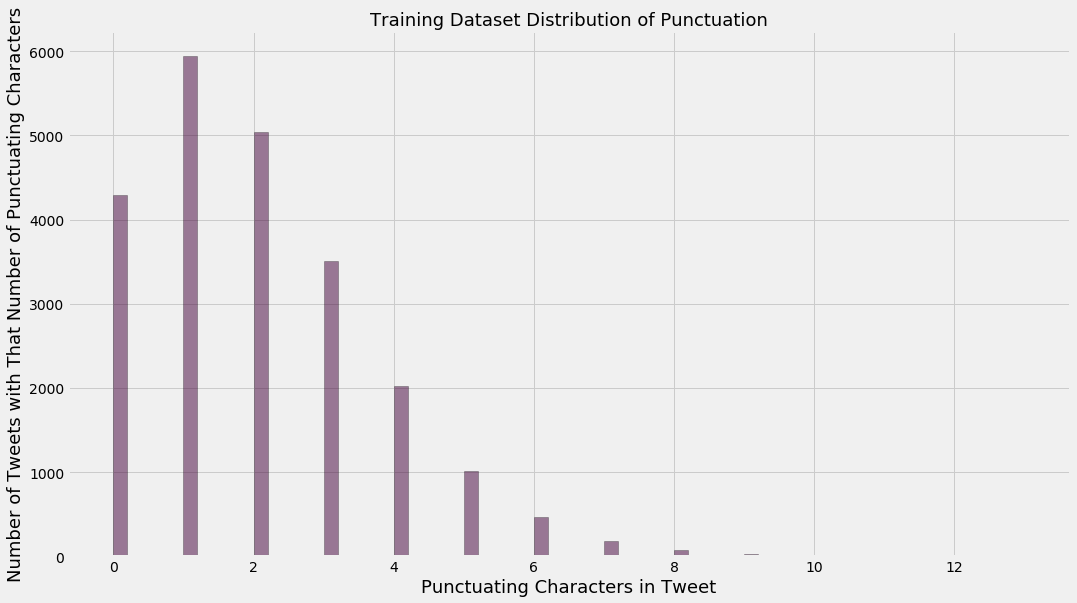

In [76]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

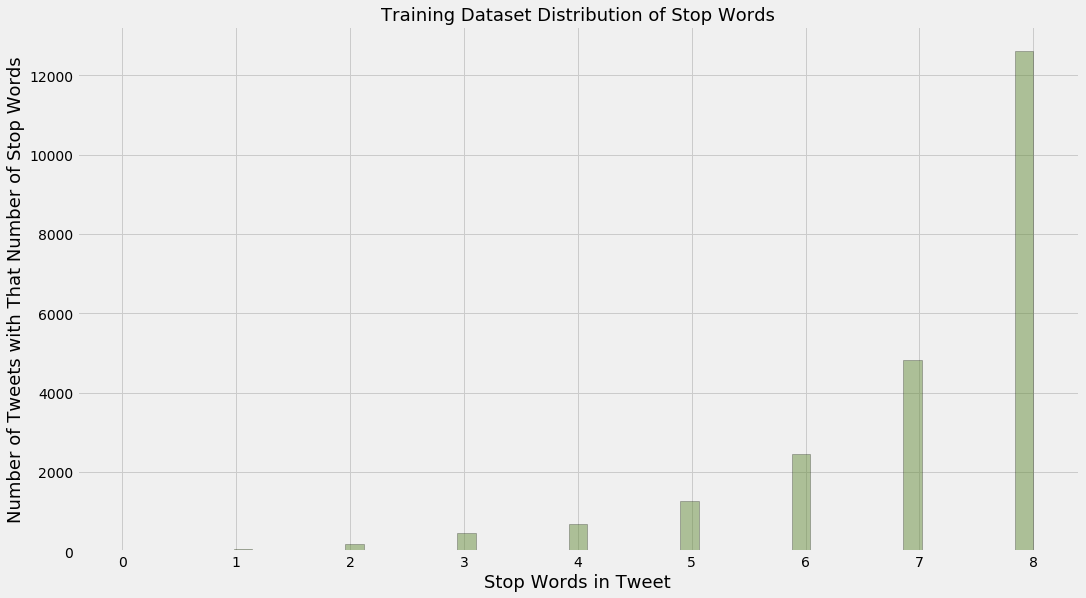

In [77]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

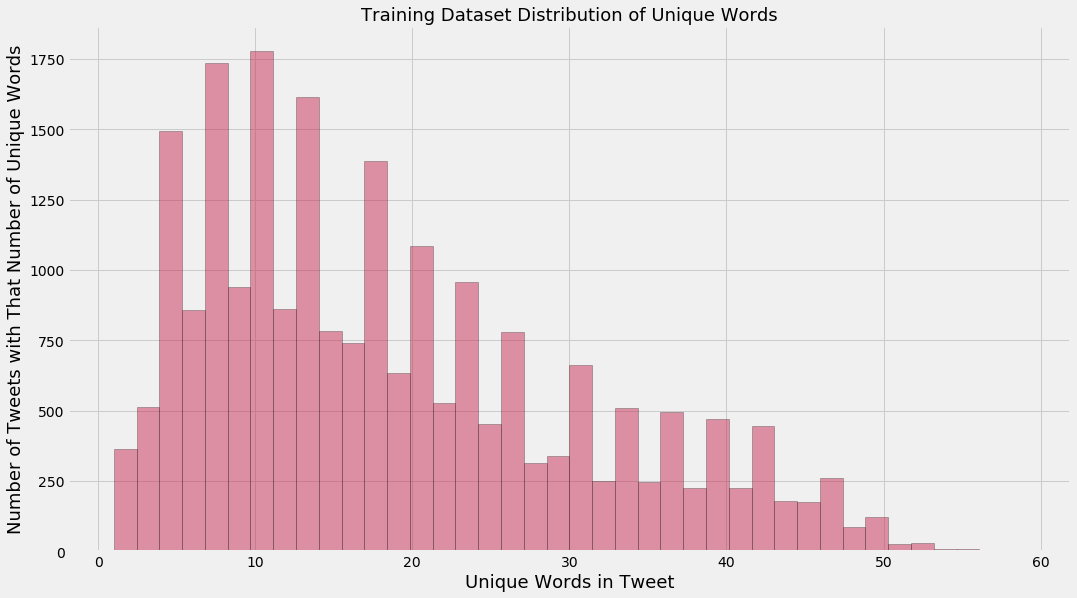

In [78]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()